# Importing the required libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [39]:
df = pd.read_csv('/content/ola.csv')
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,3,2,6.66,76.62,9.57,5,128,133
1,2011-01-01 01:00:00,4,3,13.54,55.91,4.01,36,184,220
2,2011-01-01 02:00:00,1,3,29.58,20.97,33.61,34,97,131
3,2011-01-01 03:00:00,3,1,7.40,61.64,15.85,6,47,53
4,2011-01-01 04:00:00,3,4,30.66,98.71,11.47,14,199,213


# Basic Data Understanding

In [40]:
df.shape

(10886, 9)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   weather     10886 non-null  int64  
 3   temp        10886 non-null  float64
 4   humidity    10886 non-null  float64
 5   windspeed   10886 non-null  float64
 6   casual      10886 non-null  int64  
 7   registered  10886 non-null  int64  
 8   count       10886 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 765.6+ KB


In [42]:
df.describe()

,season,weather,temp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.493937,2.491916,20.137973,59.946072,24.960981,24.517545,99.551442,124.068988
std,1.120531,1.123139,8.696625,22.987200,14.424684,14.390014,57.541131,59.449265
min,1.000000,1.000000,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,12.630000,40.040000,12.522500,12.000000,50.000000,74.000000
50%,2.000000,2.000000,20.190000,59.970000,25.000000,25.000000,100.000000,124.000000
75%,3.000000,4.000000,27.707500,79.620000,37.427500,37.000000,149.000000,174.000000
max,4.000000,4.000000,35.000000,99.980000,49.990000,49.000000,199.000000,248.000000


# Feature Engineering

In [43]:
# splitting the datetime and days that are weekend
from datetime import datetime
df['datetime'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

df['is_weekend'] = df['datetime'].dt.weekday.isin([5, 6]).astype(int)


df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,year,month,day,is_weekend
0,2011-01-01 00:00:00,3,2,6.66,76.62,9.57,5,128,133,2011,1,1,1
1,2011-01-01 01:00:00,4,3,13.54,55.91,4.01,36,184,220,2011,1,1,1
2,2011-01-01 02:00:00,1,3,29.58,20.97,33.61,34,97,131,2011,1,1,1
3,2011-01-01 03:00:00,3,1,7.40,61.64,15.85,6,47,53,2011,1,1,1
4,2011-01-01 04:00:00,3,4,30.66,98.71,11.47,14,199,213,2011,1,1,1


In [44]:
'''creating a new column called am_or_pm
If the hour is greater than 11, it returns 1 (meaning PM)
Otherwise, it returns 0 (meaning AM)'''

def am_or_pm(x):
    if x > 11:
        return 1
    else:
        return 0

df['hour'] = df['datetime'].dt.hour
df['am_or_pm'] = df['hour'].apply(am_or_pm)
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,year,month,day,is_weekend,hour,am_or_pm
0,2011-01-01 00:00:00,3,2,6.66,76.62,9.57,5,128,133,2011,1,1,1,0,0
1,2011-01-01 01:00:00,4,3,13.54,55.91,4.01,36,184,220,2011,1,1,1,1,0
2,2011-01-01 02:00:00,1,3,29.58,20.97,33.61,34,97,131,2011,1,1,1,2,0
3,2011-01-01 03:00:00,3,1,7.40,61.64,15.85,6,47,53,2011,1,1,1,3,0
4,2011-01-01 04:00:00,3,4,30.66,98.71,11.47,14,199,213,2011,1,1,1,4,0


In [45]:
# removing these columns since we have extracted useful features like year, month, day, hour
df.drop(['datetime'],
        axis=1,
        inplace=True)

# Exploratory Data Analysis

In [46]:
df.isnull().sum()

,0
season,0
weather,0
temp,0
humidity,0
windspeed,0
casual,0
registered,0
count,0
year,0
month,0


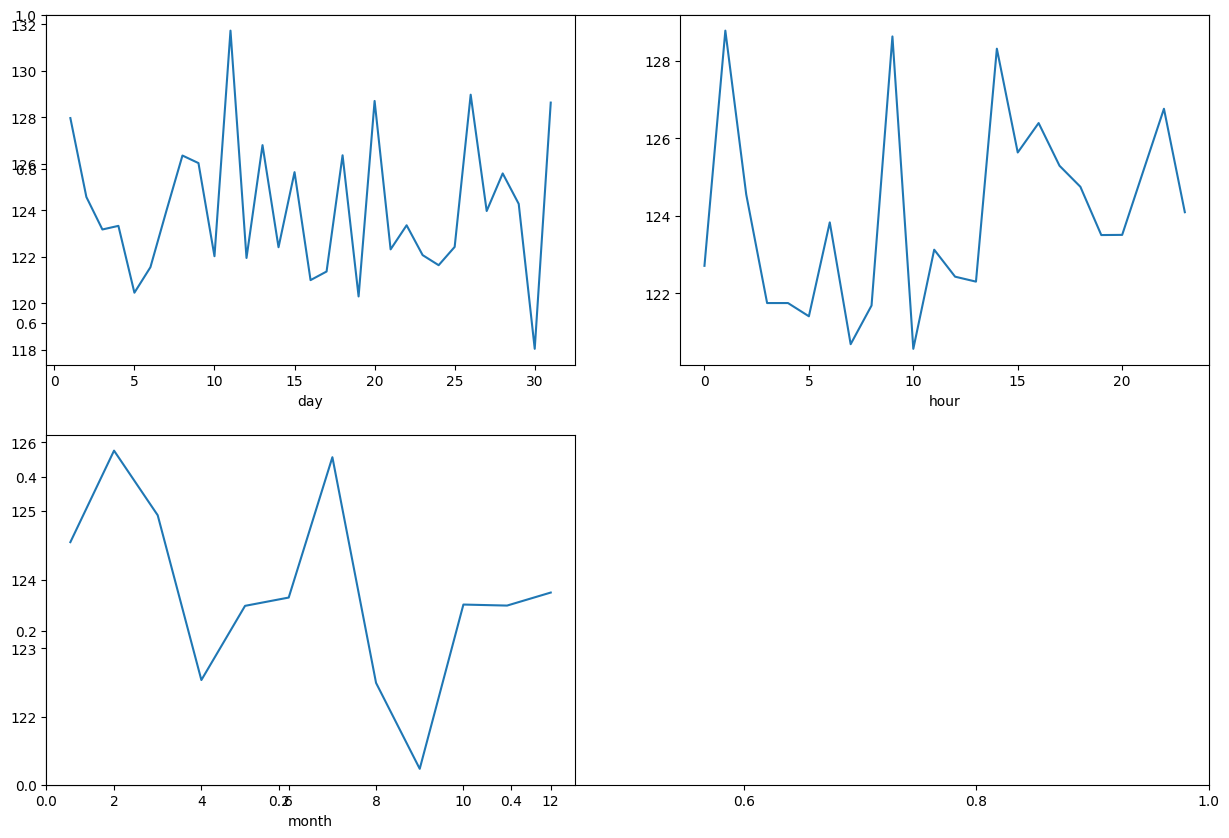

In [47]:
# Total number of users (casual + registered) by day, hour and month

features = ['day', 'hour', 'month']

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    df.groupby(col).mean()['count'].plot()
plt.show()

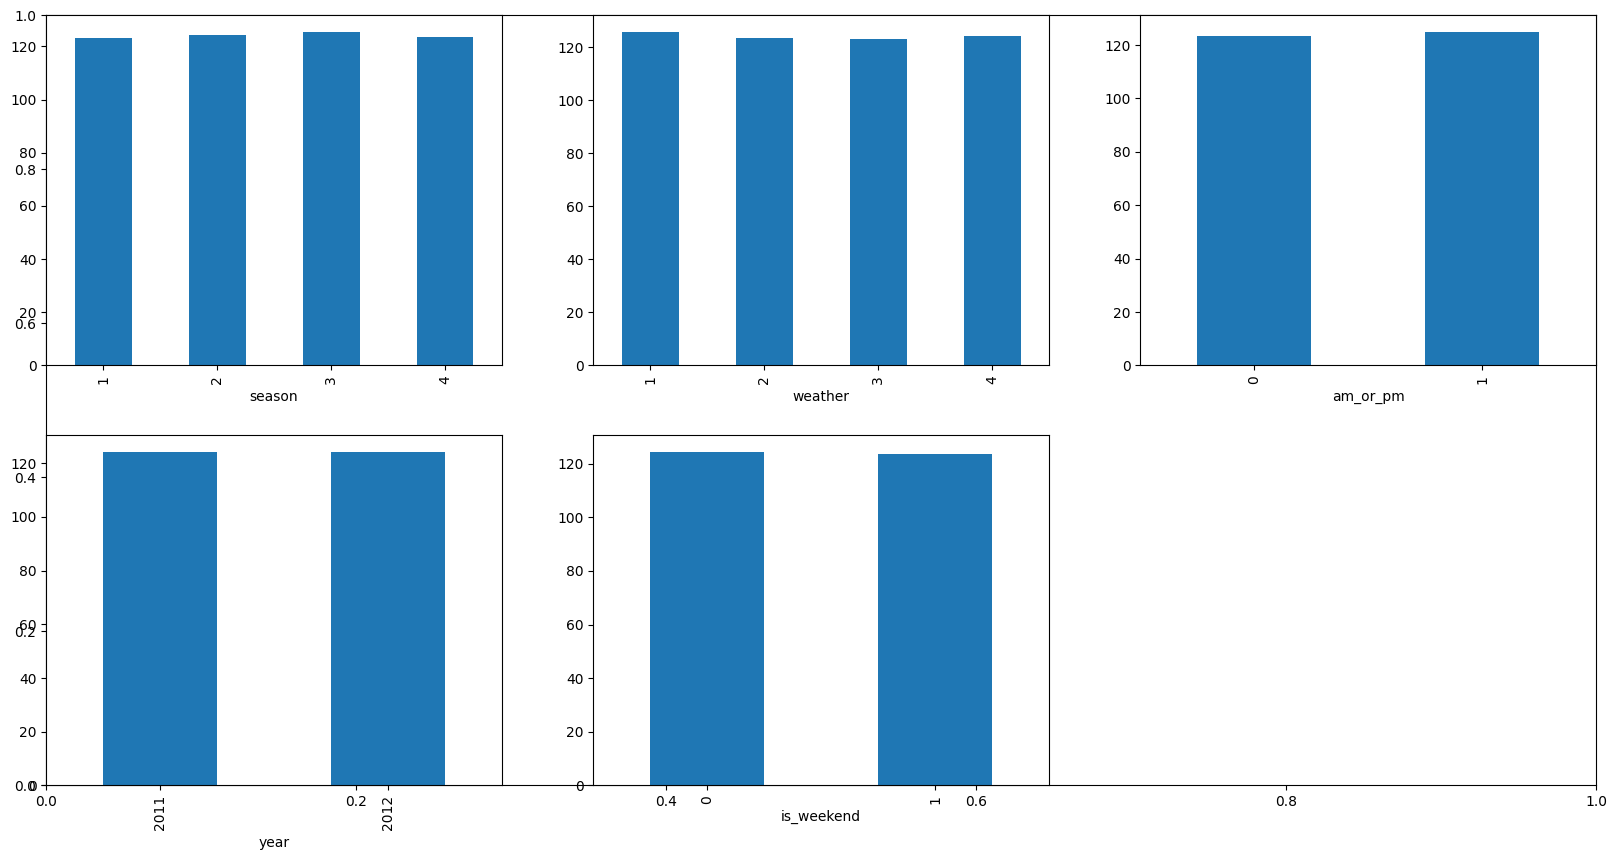

In [48]:
# average count in different seasons, or AM vs PM, or weekends vs weekdays
features = ['season', 'weather',
            'am_or_pm', 'year', 'is_weekend']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean()['count'].plot.bar()
plt.show()

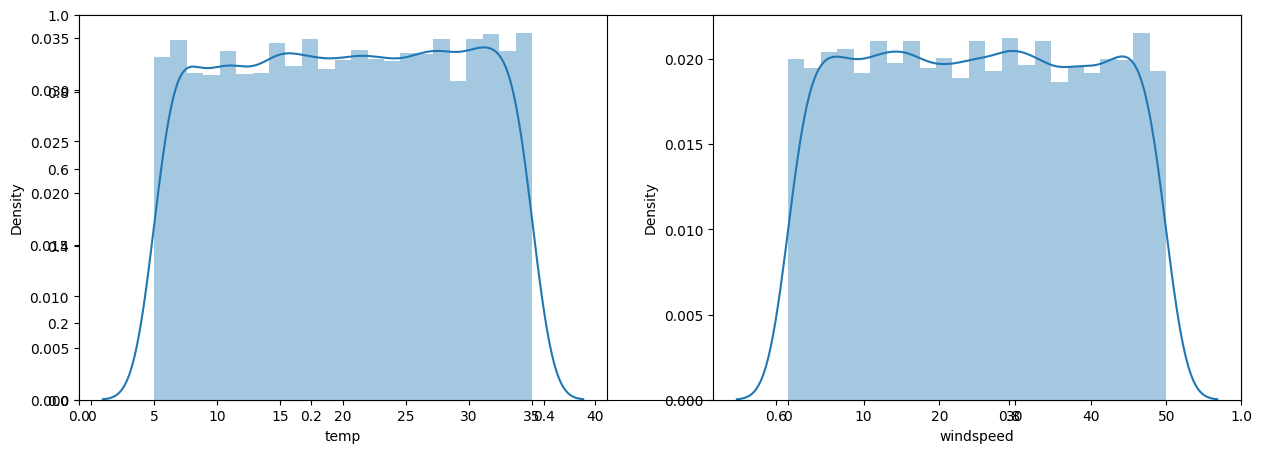

In [49]:
# distribution plots for temp and windspeed.
features = ['temp', 'windspeed']

plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
  plt.subplot(1, 2, i + 1)
  sb.distplot(df[col])
plt.show()

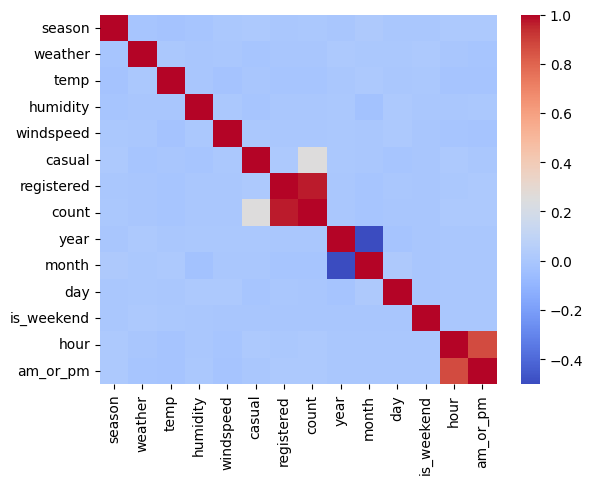

In [50]:
sb.heatmap(df.corr(),

           cmap='coolwarm')
plt.show()


# Checking outliers

In [51]:
num_cols = df.select_dtypes(include='number').columns  # select numeric columns
outlier_counts = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    outlier_counts[col] = outliers.shape[0]

print(outlier_counts)


{'season': 0, 'weather': 0, 'temp': 0, 'humidity': 0, 'windspeed': 0, 'casual': 0, 'registered': 0, 'count': 0, 'year': 2126, 'month': 0, 'day': 0, 'is_weekend': 0, 'hour': 0, 'am_or_pm': 0}


# **Phase 2: Data Clustering and Model Building**

In [52]:
# Train-test split
features = df.drop(['count', 'registered', 'casual'], axis=1)
target = df['count'].values

X_train, X_test, Y_train, Y_test = train_test_split(features,
                                                  target,
                                                  test_size = 0.2,
                                                  random_state=22)
X_train.shape, X_test.shape

((8708, 11), (2178, 11))

In [53]:
# scaling to make features equally important
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

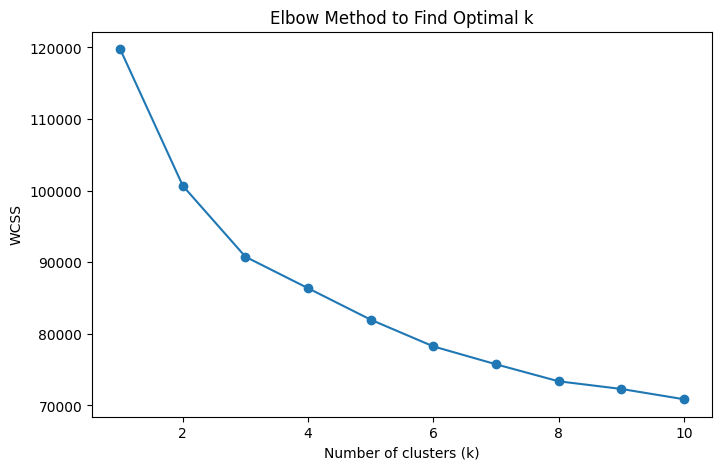

In [54]:
from sklearn.cluster import KMeans

# Scale the entire feature set before clustering
X_scaled = x_scaler.fit_transform(features)

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # within-cluster sum of squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init to suppress warning
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method to Find Optimal k')
plt.show()

In [58]:
# Apply K-means with chosen k
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

## **# Phase 3: Evaluating Various Model Approaches**

In [59]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(random_state=42),
    'Ridge': Ridge(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

results = {}

# Train and evaluate each model
for name, model in models.items():

    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred)
    results[name] = mae
    print(f"{name} MAE: {mae:.4f}")

# Display all results
print("\n--- Model Evaluation Results (MAE) ---")
for name, mae in results.items():
    print(f"{name}: {mae:.4f}")

Linear Regression MAE: 51.8391
Lasso MAE: 51.8563
Ridge MAE: 51.8391
Random Forest Regressor MAE: 52.3070
Support Vector Regressor MAE: 51.8842

--- Model Evaluation Results (MAE) ---
Linear Regression: 51.8391
Lasso: 51.8563
Ridge: 51.8391
Random Forest Regressor: 52.3070
Support Vector Regressor: 51.8842


## **Phase 4: Cross-Validation**

In [64]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = -cross_val_score(model, X_train, Y_train,
                              cv=kf, scoring='neg_mean_absolute_error')

    print(f"{name}: Mean MAE = {scores.mean():.4f}, Std = {scores.std():.4f}")


Linear Regression: Mean MAE = 50.7273, Std = 0.6622
Lasso: Mean MAE = 50.6814, Std = 0.6321
Ridge: Mean MAE = 50.7273, Std = 0.6622
Random Forest Regressor: Mean MAE = 51.3403, Std = 0.7911
Support Vector Regressor: Mean MAE = 50.7008, Std = 0.6945
